## Stats 131: Final Project
### Kaylin Dee

Basic Exploratory Analysis of League of Legends' Kaggle Data.

The data from Kaggle consists of 7 separate data sets that all contain competitive data from 2014-2018. We will be focusing on the general LeagueofLegends, the Gold, and the Structures data set for this analysis. 

###### Import Packages

In [741]:
#import packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import linear_model
from ast import literal_eval
from pandas.core.reshape.reshape import unstack

###### League of Legends DataSet

In [742]:
#import first dataset
LoL = pd.read_csv('C:/Users/Kaylin/Documents/Data Sets/League of Legends/LeagueofLegends.csv')
#LoL.info() #7620 x 57

# Variable Analyses

## Subsetting only 2017 Season Data

We chose to focus on 2017 because it is the most recent, complete year. We also only want to focus on Season rows.

In [743]:
y2017 = LoL.loc[LoL['Year'] == 2017,]
y2017 = y2017.loc[y2017['Type'] == 'Season']

## 1. Blue vs Red Wins

In [744]:
wins = y2017.groupby('Year')[['bResult', 'rResult']].sum()
print(wins)

      bResult  rResult
Year                  
2017     1456     1116


The typical question of whether blue or red side wins more games! From this simple table, it looks like blue side won 340 games more than the red side.  

## 2. Game Length

In [745]:
y2017['gamelength'].describe()

count    2572.000000
mean       36.240669
std         7.799661
min        17.000000
25%        31.000000
50%        35.000000
75%        41.000000
max        78.000000
Name: gamelength, dtype: float64

In [746]:
y2017_2 = y2017[y2017.gamelength > 65]
y2017_2.shape 

(10, 57)

There are only 10 games over 65 minutes out of the 2572. This is about 3 standard deviations above the 75% quartile.

We'll just clean it up a bit and take these out

In [747]:
y2017 = y2017[y2017.gamelength <= 65]
y2017['gamelength'].describe()

count    2562.000000
mean       36.112412
std         7.535977
min        17.000000
25%        30.000000
50%        35.000000
75%        41.000000
max        65.000000
Name: gamelength, dtype: float64

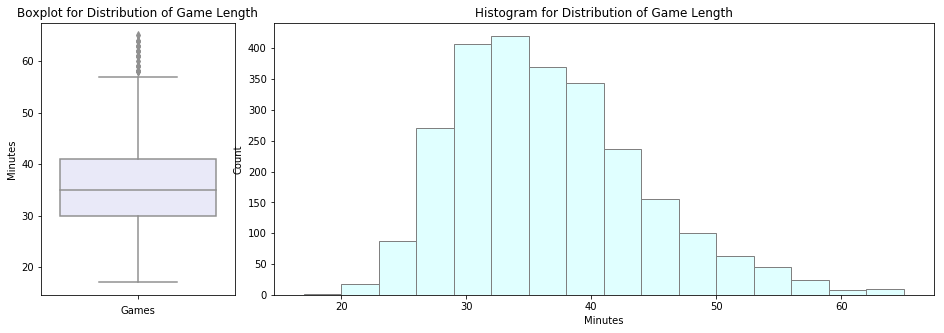

In [748]:
fig, ax = plt.subplots(0,2, figsize=(16,11))

p1 = plt.subplot2grid((2,4), (0,0), colspan = 1)
sns.boxplot(y = y2017['gamelength'], color = 'lavender')
plt.title("Boxplot for Distribution of Game Length")
plt.xlabel("Games") 
plt.ylabel("Minutes")

p2 = plt.subplot2grid((2,4), (0,1), colspan = 3)
plt.hist(x= 'gamelength', bins = 16, data = y2017, color = 'lightcyan', edgecolor = 'grey')
plt.title("Histogram for Distribution of Game Length")
plt.xlabel("Minutes")
plt.ylabel("Count")

plt.show()

From the boxplot and histogram, we can see that most competitive games during 2017 Season only lasted between 30-40 minutes long. The distribution is skewed left. Fromt the summary statistics, a game can go from 17 minutes to 78 minutes. However we decided to remove games over 65 minutes. 

## 3. Gold Difference 

In [749]:
#import the data for gold
gold = pd.read_csv('C:/Users/Kaylin/Documents/Data Sets/League of Legends/gold.csv')
gold.shape

(99060, 97)

In [750]:
#only keep gold difference type
golddiff = gold[gold.Type == 'golddiff']
golddiff.shape

(7620, 97)

In [751]:
#keep only address from the y2017 dataset in order to get the 2017 data 
justaddress2017 = y2017.Address
justaddress2017 = pd.DataFrame(justaddress2017)

In [791]:
#merge the two together in order to get gold difference in games for 2017
y2017golddiff = pd.merge(justaddress2017, golddiff, on = ['Address'])

In [753]:
#only keep columns with minutes
y2017golddiff = y2017golddiff.iloc[:,2:67]
y2017golddiff.describe()

,min_1,min_2,min_3,min_4,min_5,min_6,min_7,min_8,min_9,min_10,...,min_56,min_57,min_58,min_59,min_60,min_61,min_62,min_63,min_64,min_65
count,2562.0,2562.000000,2562.000000,2562.000000,2562.000000,2562.000000,2562.000000,2562.000000,2562.000000,2562.000000,...,42.000000,35.000000,23.000000,18.000000,15.000000,14.000000,10.000000,7.000000,4.00000,1.0
mean,0.0,-0.060109,4.124902,21.323575,40.580406,61.510929,91.534738,109.129586,135.846995,165.976581,...,-663.380952,-647.857143,-2059.173913,-2897.055556,-2759.133333,-1918.000000,-4399.200000,-3091.714286,-4531.50000,5426.0
std,0.0,71.606327,137.445215,269.450576,436.885698,557.204730,674.589142,824.737681,977.074404,1170.945356,...,5414.345714,5597.920854,5991.923038,6391.924155,6663.303812,6184.693786,5761.564271,5723.627396,8020.08485,NaN
min,0.0,-1273.000000,-1327.000000,-1544.000000,-1702.000000,-2667.000000,-2977.000000,-3723.000000,-3561.000000,-4795.000000,...,-11888.000000,-12275.000000,-11198.000000,-11062.000000,-11509.000000,-10146.000000,-11826.000000,-9259.000000,-12452.00000,5426.0
25%,0.0,0.000000,-42.000000,-113.750000,-176.000000,-256.000000,-326.500000,-417.000000,-465.250000,-536.750000,...,-4269.250000,-6007.500000,-7227.500000,-8301.500000,-8099.500000,-7585.000000,-8515.500000,-7759.500000,-10907.00000,5426.0
50%,0.0,0.000000,5.000000,15.000000,32.000000,53.500000,76.000000,84.000000,89.500000,113.000000,...,-535.500000,796.000000,-4088.000000,-4078.500000,-4832.000000,-2221.500000,-6458.500000,-3853.000000,-4357.00000,5426.0
75%,0.0,0.000000,52.000000,142.000000,256.750000,389.750000,509.750000,625.500000,701.500000,834.250000,...,2639.000000,2955.000000,2801.000000,2642.000000,3526.000000,4193.250000,-442.750000,783.500000,2018.50000,5426.0
max,0.0,875.000000,1055.000000,1434.000000,1927.000000,2038.000000,2568.000000,3877.000000,4288.000000,5526.000000,...,10284.000000,10651.000000,8926.000000,8097.000000,6676.000000,6938.000000,5339.000000,5422.000000,3040.00000,5426.0


Average Gold Difference for 2017 competitive games for each minute

In [754]:
#only select the mean from the describe table
y2017golddiff_df = pd.DataFrame(y2017golddiff.describe())
y2017golddiff_mean = y2017golddiff_df.loc['mean']

In [755]:
#turn the mean and minute into a data frame
y2017golddiff_mean = pd.DataFrame(y2017golddiff_mean)
y2017golddiff_mean.head() #should match the describe() means

,mean
min_1,0.000000
min_2,-0.060109
min_3,4.124902
min_4,21.323575
min_5,40.580406


In [756]:
#reindex so it's easier to plot (matching index with minute)
y2017golddiff_mean.reset_index(level=0, inplace=True)
y2017golddiff_mean.index = y2017golddiff_mean.index + 1

y2017golddiff_mean.head()

,index,mean
1,min_1,0.000000
2,min_2,-0.060109
3,min_3,4.124902
4,min_4,21.323575
5,min_5,40.580406


Make a plot of average gold difference over time

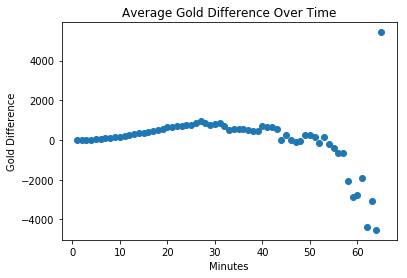

In [790]:
plt.scatter(x = y2017golddiff_mean.index, y = y2017golddiff_mean['mean'])
plt.title('Average Gold Difference Over Time')
plt.xlabel('Minutes')
plt.ylabel('Gold Difference')
plt.show()

From this plot, we can see that as time gets toward the tail-end of game length (over 40 minutes), the average gold difference becomes rather drastic. This could be because once the game goes longer, one of the teams will start getting more and more ahead of the other. 

## 4. Most and Least Banned Champions in 2017

In [759]:
blueBans2017 = y2017['blueBans'].apply(literal_eval)
redBans2017 = y2017['redBans'].apply(literal_eval)

bans = blueBans2017.append(redBans2017) #combine the red and blue bans for a total bans data frame

In [760]:
dfBans = pd.DataFrame(bans) #create the data frame
dfBans.columns = ["bans"] #rename the column 

In [761]:
dfBans.shape #to check if both columns were combined correctly, the shape needs 6622 rows because the original set had 3311 obs
dfBans.head()

,bans
609,"[Rengar, Olaf, Janna, Nautilus, Poppy]"
610,"[Zyra, Maokai, Ryze, Fiora, Jayce]"
611,"[Zyra, Syndra, Ryze, Orianna, Karma]"
612,"[Ryze, Kennen, Malzahar, Zyra, Rumble]"
613,"[Kalista, Olaf, Zyra, MissFortune, Ekko]"


In [762]:
lst_col = 'bans'

#get the names out of the 'pseudo'-list
b = pd.DataFrame({
    col:np.repeat(dfBans[col].values, dfBans[lst_col].str.len())
    for col in dfBans.columns.drop(lst_col)}).assign(**{lst_col:np.concatenate(dfBans[lst_col].values)})[dfBans.columns]

b.shape #25437 total bans in 2017 for competitive matches

(25437, 1)

In [763]:
#get the total each champion in 2017 was banned in competitive matches
common1 = b.groupby('bans')['bans'].count()

In [764]:
#sort from largest to smallest; observe the top 10
mostcommon1sort =common1.sort_values(ascending = False)[0:10]

#sort from smallest to largest; observe top 10
leastcommon1sort = common1.sort_values(ascending= True)[0:10]

In [765]:
#turn into a dataframe
leastcommon1df= pd.DataFrame(leastcommon1sort)
leastcommon1df = leastcommon1df.reindex(leastcommon1df.index.rename('Champion'))
leastcommon1df.reset_index(level=0, inplace=True)

In [766]:
#turn into a dataframe
mostcommon1df= pd.DataFrame(mostcommon1sort)
mostcommon1df = mostcommon1df.reindex(mostcommon1df.index.rename('Champion'))
mostcommon1df.reset_index(level=0, inplace=True)

In [767]:
print(mostcommon1df)

  Champion  bans
0  Leblanc  1516
1  Camille  1159
2   Syndra  1082
3      Zac  1078
4    Elise   995
5  Caitlyn   840
6    Jayce   836
7   Rengar   788
8     Shen   785
9   Thresh   683


In [768]:
print(leastcommon1df)

       Champion  bans
0       DrMundo     1
1        Xerath     1
2         Amumu     1
3           Lux     1
4         Quinn     1
5          Sona     1
6         Shaco     1
7         Diana     1
8  Fiddlesticks     2
9          Jinx     2


Text(0.5,1,'Least Banned Champions of 2017 Season')

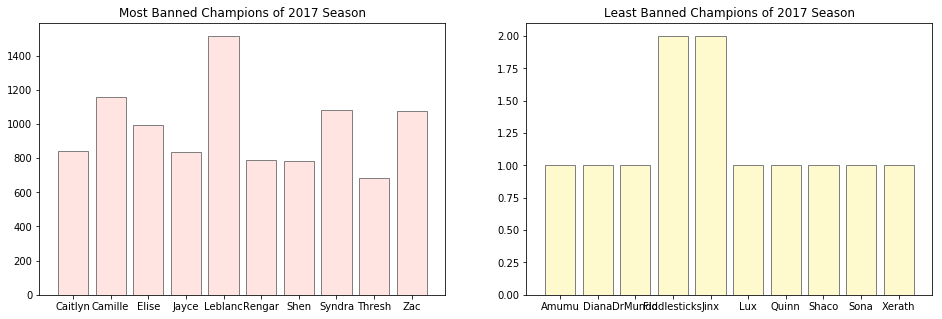

In [794]:
fig, ax = plt.subplots(0,2, figsize=(16,11))

p1 = plt.subplot(221)
mostchart = plt.bar(mostcommon1df['Champion'], mostcommon1df['bans'], color = 'mistyrose', edgecolor = 'grey')
plt.title('Most Banned Champions of 2017 Season')

p2 = plt.subplot(222)
leastchart = plt.bar(leastcommon1df['Champion'], leastcommon1df['bans'], color = 'lemonchiffon', edgecolor = 'grey')
plt.title('Least Banned Champions of 2017 Season')

From these table and barplot, we can see that the most common champion banned during the 2017 Season was LeBlanc and the least banned were Amumu, Diana, Mundo, Lux, Quinn, Shaco, Sona, and Xerath. 

LeBlanc was banned over 1516 times out of the 2562 competitive games. Meanwhile, there were 8 champions that were only banned once. Surprisingly, this indicates that every champion during 2017 was banned at least once! There were none that were left out of the big screen ban picks. 

# Modeling 

### What times should you take down the first structure in order to increase your chance of winning the game?

Does taking down the first tower/objective earlier increase your chances of winning?

We need to use the structures data set in the League of Legends Kaggle Data zip file and merge it with the general LoL set. 

First we will read in the structures and group by the Address. We will only be keeping the Time variable and find the minimum, which indicates when the first tower is taken down. 

Once we find when the first tower was taken down, we need to find out which team took it and if that team won. 


In [770]:
structures = pd.read_csv('C:/Users/Kaylin/Documents/Data Sets/League of Legends/structures.csv')

In [771]:
timetable = structures.groupby('Address')['Time'].min() 
#Only get the first tower data

In [772]:
timetable.shape 
#Check if this matches the LoL data shape
#Should only be one per game recorded

(7620,)

In [773]:
timetabledf = pd.DataFrame(timetable)
timetabledf.reset_index(level=0, inplace=True)
timetabledf.head()

,Address,Time
0,http://matchhistory.br.leagueoflegends.com/pt/...,9.397
1,http://matchhistory.br.leagueoflegends.com/pt/...,8.670
2,http://matchhistory.br.leagueoflegends.com/pt/...,9.075
3,http://matchhistory.br.leagueoflegends.com/pt/...,9.340
4,http://matchhistory.br.leagueoflegends.com/pt/...,13.053


Merge the two data sets and only include the smallest time a tower was taken down. Then merge this data set into the original LoL data.

In [774]:
structures_merge = pd.merge(structures,timetabledf, on=['Address', 'Time'])

In [775]:
structuresLoL_merge = pd.merge(structures_merge, LoL, on = ['Address'])
structuresLoL_merge.shape

(7622, 61)

In [776]:
structuresLoL = structuresLoL_merge[['Time', 'Team', 'Lane', 'Year', 'Address', 'bResult', 'rResult', 'Type_y']]

Keep only 2017 Season Data

In [777]:
structuresLoL2017 = structuresLoL[structuresLoL.Year == 2017]
structuresLoL2017_season = structuresLoL2017[structuresLoL2017.Type_y == 'Season']

### Quick Exploratory Analysis of the New Data Set

In [778]:
print(structuresLoL2017_season.groupby(['Year'])['bResult', 'rResult'].sum())

      bResult  rResult
Year                  
2017     1456     1117


In [779]:
structuresLoL2017_season['Time'].min()

4.206

The shortest time to take down a tower was about 4 minutes.

In [780]:
structuresLoL2017_season.groupby(['bResult', 'rResult'])['Time'].mean()

bResult  rResult
0        1          12.611315
1        0          12.542127
Name: Time, dtype: float64

The average time for the winning blue team to take down a tower is about 12.54 minutes while the average time for the winning red team to take down a tower is 12.61 minutes. They're basically equal. 

In [781]:
lanetowers1 = structuresLoL2017_season.groupby('Lane')['Lane'].count()
lanetowers1df = pd.DataFrame(lanetowers1)

print(lanetowers1df)

          Lane
Lane          
BOT_LANE  1324
MID_LANE   365
TOP_LANE   884


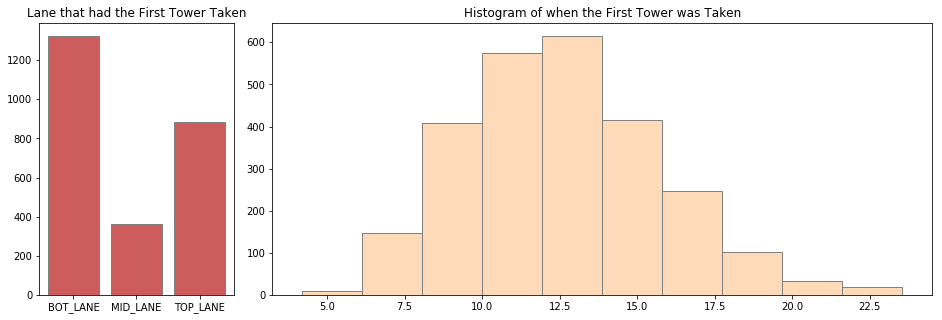

In [782]:
fig, ax = plt.subplots(0,2, figsize=(16,11))

p1 = plt.subplot2grid((2,4), (0,0), colspan = 1)
barchart = plt.bar(lanetowers1df.index, lanetowers1df['Lane'], 
                   color = 'indianred', edgecolor = 'grey')
plt.title('Lane that had the First Tower Taken')

p2 = plt.subplot2grid((2,4), (0,1), colspan = 3)
plt.hist(structuresLoL2017_season.Time, color = 'peachpuff', 
         edgecolor = 'grey')
plt.title('Histogram of when the First Tower was Taken')

plt.show()

For the barplot, we can observe the count of towers that were the first to be taken down in the data set. It seems that Bottom Lane towers are the most frequent in being the first to go all 2017 competitive games recorded. Meanwhile, the Mid Lane tower seems to be the least. 

The histogram depicts the amount of time taken for the first tower to be taken down. 10-15 minutes appears to be a common time the first structure falls, but for a few games it took over 20 minutes.

### Building a Logistic Model

We want to see if there's a time a team should take down a tower in order to increase their chances in winning. 

We will only be using the variables: Time and Result

In [783]:
from patsy import dmatrices
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn.cross_validation import cross_val_score

Prepare the data

In [784]:
y, X = dmatrices('bResult ~ Time + Team', structuresLoL2017, return_type = "dataframe")

print(X.columns)

Index(['Intercept', 'Team[T.rTowers]', 'Time'], dtype='object')


Flatten y to 1-D array

In [785]:
y = np.ravel(y)

Run model on entire data set to see how accurate: 

In [786]:
model = LogisticRegression()
model = model.fit(X,y)
model.score(X,y)

0.6850845410628019

As of now, we have about a 68.51% accuracy in predicting the chances of winning. 

In [787]:
X.columns, model.coef_

(Index(['Intercept', 'Team[T.rTowers]', 'Time'], dtype='object'),
 array([[ 0.5140865 , -1.51471327, -0.01118849]]))

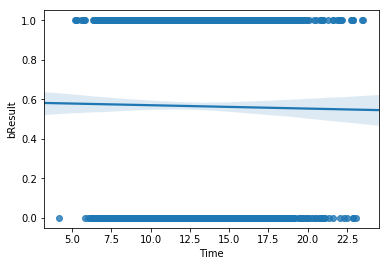

In [788]:
sns.regplot(x = 'Time', y = 'bResult', data = structuresLoL2017_season, logistic = True)

In [789]:
#TeamFactor = pd.factorize(structuresLoL2017_season.Team)[0]
#structuresLoL2017_season['TeamFactor'] = TeamFactor